In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [4]:
g_sub = od+expand(config['lr']['subsample']['gene_summary'], species='human')[0]
t_sub = od+expand(config['lr']['subsample']['transcript_summary'], species='human')[0]

## Correlate gene / transcript expression from whole thing to subsampled things

In [114]:
subs_filt_ab = '~/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/subsample/cerberus_filtered_abundance_0.9_1.tsv'
subs_ab = '~/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/subsample/unfilt_talon_abundance_0.9_1.tsv'

In [149]:
files = [subs_filt_ab]

file_df = pd.DataFrame()
file_df['file'] = list(files)
file_df['depth'] = file_df.file.str.rsplit('_', n=2, expand=True)[1]
file_df['rep'] = file_df.file.str.rsplit('_', n=1, expand=True)[1].str.rsplit('.', n=1, expand=True)[0]
file_df

,file,depth,rep
0,~/mortazavi_lab/data/paper_rnawg/proc_revision...,0.9,1


In [154]:
def get_corr_t_summary(files, ofile, params):
    files = [subs_filt_ab]

    file_df = pd.DataFrame()
    file_df['file'] = list(files)
    file_df['depth'] = file_df.file.str.rsplit('_', n=2, expand=True)[1]
    file_df['rep'] = file_df.file.str.rsplit('_', n=1, expand=True)[1].str.rsplit('.', n=1, expand=True)[0]
    
    spearman_corrs = []
    pearson_corrs = []
    gs = []
    reps = []
    depths = []
    
    gene_subsets = params['gene_subsets']
    min_tpm = params['min_tpm']

    for ind, entry in file_df.iterrows():
        file = entry.file
        depth = entry.depth
        rep =  entry.depth
        for g in gene_subsets:
            ab_df = pd.read_csv(filt_ab, sep='\t')
            ab_df, _ = get_tpm_table(ab_df,
                                    how='iso',
                                    gene_subset=g,
                                    min_tpm=min_tpm,
                                     groupby='sample',
                                    sample=['wtc11'])
            ab_df = ab_df.reset_index()
            ab_df.rename({'index': 'tid'}, axis=1, inplace=True)

            sub_ab_df = pd.read_csv(file, sep='\t')
            sub_ab_df, _ = get_tpm_table(sub_ab_df,
                                    how='iso',
                                    gene_subset=g,
                                    min_tpm=min_tpm,
                                         groupby='sample',
                                    sample=['wtc11'])
            sub_ab_df = sub_ab_df.reset_index()
            sub_ab_df.rename({'index': 'tid'}, axis=1, inplace=True)

            # intersection (only correlate stuff detected in both)
            temp = ab_df.merge(sub_ab_df, how='inner',
                     on='tid',
                     suffixes=('_full', '_subs'))

            x = 'wtc11_full'
            y = 'wtc11_subs'
            rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
            r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())    
            spearman_corrs.append(r)
            pearson_corrs.append(rho)
            gs.append(g)
            reps.append(rep)
            depths.append(depth)

        corr_df = pd.DataFrame()
        corr_df['depth'] = depths
        corr_df['rep'] = reps
        corr_df['gene_subset'] = gs
        corr_df['pearson_r'] = pearson_corrs
        corr_df['spearman_rho'] = spearman_corrs
        corr_df.to_csv(ofile, sep='\t', index=False)



In [156]:
params = dict()
params['min_tpm'] = 1
params['gene_subsets'] = ['protein_coding', 'lncRNA', 'pseudogene']
subs_filt_ab = '~/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/subsample/cerberus_filtered_abundance_0.9_1.tsv'
get_corr_t_summary([subs_filt_ab], 'test_wtc11_subs_t_corr_summary.tsv', params)


Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 61442
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 102899
# isos >= 1 tpm: 77993
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 74222
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for lncRNA genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 1761
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for lncRNA genes
Enforcing minimum TPM
Total # isos detected: 102899
# isos >

In [152]:
# get expression values from entire sample * condition
gene_subsets = ['protein_coding', 'lncRNA', 'pseudogene']
min_tpm = 1

spearman_corrs = []
pearson_corrs = []
gs = []
reps = []
depths = []

for ind, entry in file_df.iterrows():
    file = entry.file
    depth = entry.depth
    rep =  entry.depth
    for g in gene_subsets:
        ab_df = pd.read_csv(filt_ab, sep='\t')
        ab_df, _ = get_tpm_table(ab_df,
                                how='iso',
                                gene_subset=g,
                                min_tpm=min_tpm,
                                 groupby='sample',
                                sample=['wtc11'])
        ab_df = ab_df.reset_index()
        ab_df.rename({'index': 'tid'}, axis=1, inplace=True)

        sub_ab_df = pd.read_csv(file, sep='\t')
        sub_ab_df, _ = get_tpm_table(sub_ab_df,
                                how='iso',
                                gene_subset=g,
                                min_tpm=min_tpm,
                                     groupby='sample',
                                sample=['wtc11'])
        sub_ab_df = sub_ab_df.reset_index()
        sub_ab_df.rename({'index': 'tid'}, axis=1, inplace=True)
        
        # intersection (only correlate stuff detected in both)
        temp = ab_df.merge(sub_ab_df, how='inner',
                 on='tid',
                 suffixes=('_full', '_subs'))
    
        x = 'wtc11_full'
        y = 'wtc11_subs'
        rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
        r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())    
        spearman_corrs.append(r)
        pearson_corrs.append(rho)
        gs.append(g)
        reps.append(rep)
        depths.append(depth)

corr_df = pd.DataFrame()
corr_df['depth'] = depths
corr_df['rep'] = reps
corr_df['gene_subset'] = gs
corr_df['pearson_r'] = pearson_corrs
corr_df['spearman_rho'] = spearman_corrs

        

Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 61442
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 102899
# isos >= 1 tpm: 77993
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 74222
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for lncRNA genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 64107
Applying gene type and novelty subset
Averaging over biosample
Found 1 total samples
Number of isos reported: 1761
Calculating iso TPM values
Subsetting for ['wtc11'] samples
Subsetting for lncRNA genes
Enforcing minimum TPM
Total # isos detected: 102899
# isos >

In [153]:
corr_df

,depth,rep,gene_subset,pearson_r,spearman_rho
0,0.9,0.9,protein_coding,0.993272,0.999974
1,0.9,0.9,lncRNA,0.985289,0.999875
2,0.9,0.9,pseudogene,0.988649,0.999912


In [144]:
temp

biosample,tid,wtc11_full,wtc11_subs
0,"ENSG00000000003[1,1,1]",2.424562,2.693901
1,"ENSG00000000003[1,1,5]",22.685900,21.713506
2,"ENSG00000000003[1,1,6]",0.830800,0.566273
3,"ENSG00000000003[1,1,7]",69.029382,68.763786
4,"ENSG00000000003[1,1,8]",36.223571,34.894535
...,...,...,...
60661,"ENSG00000285976[1,1,1]",23.970848,22.267408
60662,"ENSG00000285976[1,1,2]",78.561680,80.205322
60663,"ENSG00000285976[1,1,4]",7.590271,7.465253
60664,"ENSG00000285976[2,1,1]",81.570059,83.669458


In [143]:
len(temp.index)

60666

## Reads post-TALON for WTC11

In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta.loc[meta['sample'] == 'wtc11']
print(meta[['sample', 'dataset', 'reads_post_talon']])
print(f'{meta.reads_post_talon.sum(axis=0)} wtc11 reads post-talon')

    sample    dataset  reads_post_talon
135  wtc11  wtc11_1_1           2332639
136  wtc11  wtc11_1_2           1358180
137  wtc11  wtc11_1_3           2851975
6542794 wtc11 reads post-talon


## Gene / transcript saturation plots @ different depths

In [94]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

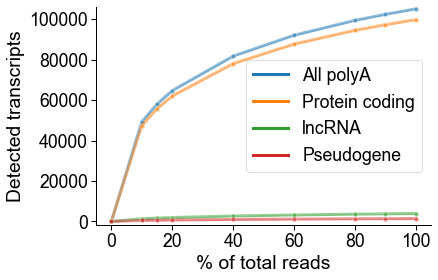

In [101]:
df = pd.read_csv(t_sub, sep='\t')
temp = pd.DataFrame()
subsets = ['polya', 'protein_coding', 'pseudogene', 'lncRNA']
zeroes = [0 for i in range(len(subsets))]
temp['n_transcripts'] = zeroes
temp['depth'] = zeroes
temp['rep'] = zeroes
temp['gene_subset'] = subsets
df = pd.concat([df, temp], axis=0)

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='n_transcripts',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
           ylim=(-1500,106000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
   
fname = 'figures/subsample_wtc11_transcript_det.pdf'
plt.savefig(fname, dpi=500)

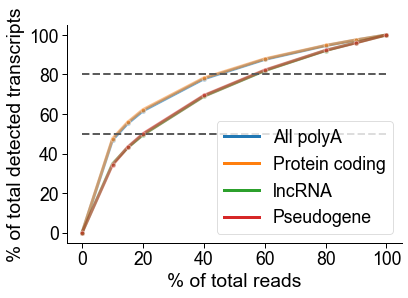

In [102]:
temp = df.copy(deep=True)
temp = temp.loc[(temp.rep==0)&(temp.perc==100)]
temp.drop_duplicates(inplace=True)
temp = temp[['n_transcripts', 'gene_subset']]
temp.rename({'n_transcripts':'n_total_transcripts'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='gene_subset')
df['perc_total_transcripts'] = (df.n_transcripts/df.n_total_transcripts)*100

sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='perc_total_transcripts',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='% of total detected transcripts',
           ylim=(-5,105), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

color = '#5c5c5c'
ax.hlines(50, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)
ax.hlines(80, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)

fname = 'figures/subsample_wtc11_transcript_det_perc.pdf'
plt.savefig(fname, dpi=500)

In [108]:
# when do we hit 50% and 80% detection?
df = df.sort_values(by='perc_total_transcripts', ascending=True)
for subset in ['polya', 'protein_coding', 'lncRNA', 'pseudogene']:
    for thresh in [50, 80]:
        print()
        print()
        print('entry:')
        print(df.loc[(df.gene_subset==subset)&(df.perc_total_transcripts>=thresh)].head(1))



entry:
    n_transcripts  depth  rep gene_subset gene_subset_2  perc  \
52          57921   0.15    3       polya     All polyA  15.0   

    n_total_transcripts  perc_total_transcripts  
52               105099               55.110895  


entry:
     n_transcripts  depth  rep gene_subset gene_subset_2  perc  \
188          91914    0.6    7       polya     All polyA  60.0   

     n_total_transcripts  perc_total_transcripts  
188               105099               87.454686  


entry:
    n_transcripts  depth  rep     gene_subset   gene_subset_2  perc  \
53          55646   0.15    3  protein_coding  Protein coding  15.0   

    n_total_transcripts  perc_total_transcripts  
53                99758                55.78099  


entry:
     n_transcripts  depth  rep     gene_subset   gene_subset_2  perc  \
189          87529    0.6    7  protein_coding  Protein coding  60.0   

     n_total_transcripts  perc_total_transcripts  
189                99758               87.741334  


entry:

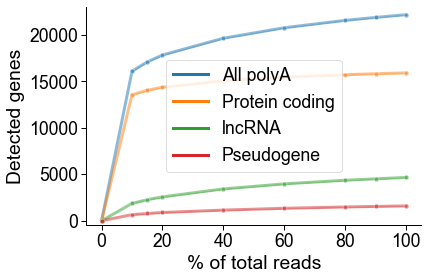

In [98]:
df = pd.read_csv(g_sub, sep='\t')
temp = pd.DataFrame()
subsets = ['polya', 'protein_coding', 'pseudogene', 'lncRNA']
zeroes = [0 for i in range(len(subsets))]
temp['n_genes'] = zeroes
temp['depth'] = zeroes
temp['rep'] = zeroes
temp['gene_subset'] = subsets
df = pd.concat([df, temp], axis=0)

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
ax = sns.lineplot(df, x='perc', y='n_genes',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='Detected genes',
           ylim=(-400,23000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
    
fname = 'figures/subsample_wtc11_gene_det.pdf'
plt.savefig(fname, dpi=500)

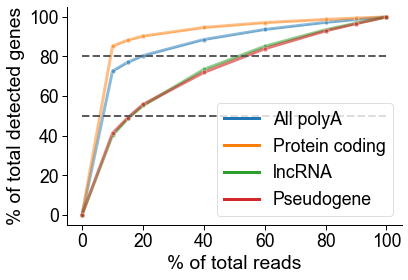

In [99]:
temp = df.copy(deep=True)
temp = temp.loc[(temp.rep==0)&(temp.perc==100)]
temp.drop_duplicates(inplace=True)
temp = temp[['n_genes', 'gene_subset']]
temp.rename({'n_genes':'n_total_genes'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='gene_subset')
df['perc_total_genes'] = (df.n_genes/df.n_total_genes)*100

sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='perc_total_genes',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='% of total detected genes',
           ylim=(-5,105), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

color = '#5c5c5c'
ax.hlines(50, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)
ax.hlines(80, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
    
fname = 'figures/subsample_wtc11_gene_det_perc.pdf'
plt.savefig(fname, dpi=500)

In [100]:
# when do we hit 50% and 80% detection?
df = df.sort_values(by='perc_total_transcripts', ascending=True)
for subset in ['polya', 'protein_coding', 'lncRNA', 'pseudogene']:
    for thresh in [50, 80]:
        print(df.loc[(df.gene_subset==subset)&(df.perc_total_transcripts>=thresh)].head(1))

KeyError: 'perc_total_transcripts'

In [63]:
# # individually
# df = pd.read_csv(t_sub, sep='\t')

# sns.set_context('paper', font_scale=2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42

# ic_colors, order = get_ic_nov_colors()
# c = ic_colors['Known']
# m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
#      'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
# cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
# df['gene_subset_2'] = df.gene_subset.map(m)
# df['gene_subset_2'] = df['gene_subset_2'].astype('category')
# df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
# c_dict, order = get_shade_colors(c, cats)

# df['perc'] = df.depth*100

# # log the transcript numbers
# df['log_n_transcripts'] = np.log2(df.n_transcripts)

# for c in df.gene_subset_2.unique().tolist():
#     temp = df.loc[df.gene_subset_2==c]
#     # add 0-read samples
#     temp2 = pd.DataFrame(data=[[0, 0, c]], columns=['n_transcripts', 'perc', 'gene_subset_2'])
#     temp = pd.concat([temp, temp2], axis=0)
#     ax = sns.lineplot(temp, x='perc', y='n_transcripts',
#                       hue='gene_subset_2', palette=c_dict,
#                       linewidth=1, marker='o', err_style='bars')
#     # ax = sns.lineplot(temp, x='perc', y='log_n_transcripts',
#     #               hue='gene_subset_2', palette=c_dict,
#     #               linewidth=1, marker='o', err_style='bars')
#     _ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
#                ylim=(-1000,106000), xlim=(-5,105))
#     # _ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
#     #             xlim=(-5,105), yscale='log')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     ax.legend_.set_title(None)

#     # get the legend object
#     leg = ax.legend()

#     # change the line width for the legend
#     for line in leg.get_lines():
#         line.set_linewidth(3)
        
#     plt.show()

In [64]:
# df.head()